In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Deep Dive into Normalization

In [2]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from torch import nn, optim, tensor
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [3]:
# Importing and setting seaborn for improved plots
#import seaborn as sns; sns.set(style='white')
# Importing partials module
from functools import partial

## Initial Setup - Taking Previous NBs Into Account

**This is just to illustrate the amount of work that goes into building a customized DL library for experimentation and model building.**

**The best method is to utilize the auto-export script and import all the necessary classes and modules.**

### Exports of NB1

In [4]:
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

### Exports of NB2

In [5]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

def normalize(x, m, s): return (x-m)/s

def test_near_zero(a,tol=1e-3): assert a.abs()<tol, f"Near zero: {a}"

from torch.nn import init

def mse(output, targ): return (output.squeeze(-1) - targ).pow(2).mean()

from torch import nn

### Exports of NB3

In [6]:
import torch.nn.functional as F

def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

from torch import optim

class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

### Exports of NB4

In [7]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset
    

def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,data.c))
    return model, optim.SGD(model.parameters(), lr=lr)


class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

        
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')

def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')

    
from typing import *


def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]


class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train

    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)

    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]

    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn


### Exports of NB5

In [8]:
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

def get_model_func(lr=0.5): return partial(get_model, lr=lr)

def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs

    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)

    def begin_batch(self):
        if self.in_train: self.set_param()

def pg_dicts(pgs): return [{'params':o} for o in pgs]


### Exports of NB5b

In [9]:
class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)

    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')

    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0

    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1

    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        self.in_train = False
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb,yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')

        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)

    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()

    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)

    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])

    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs

    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)

    def begin_batch(self):
        if self.in_train: self.set_param()

class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9

    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr

    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

### Exports of NB6

In [10]:
# Enable CUDA
#device = torch.device('cuda', 0)
#torch.cuda.set_device(device)

In [11]:
torch.set_num_threads(2)

def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    if mod.training:
        means.append(outp.data.mean())
        stds .append(outp.data.std())

class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        try: return self.items[idx]
        except TypeError:
            if isinstance(idx[0],bool):
                assert len(idx)==len(self) # bool mask
                return [o for m,o in zip(idx,self.items) if m]
            return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)

    def remove(self):
        for h in self: h.remove()

def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x):
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

## Building the ConvNet

In [12]:
x_train, y_train, x_valid, y_valid = get_data()
# Normalizing
x_train, x_valid = normalize_to(x_train, x_valid)
# Build Datasets
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

# Arch
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy

# Create databunch
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [54]:
# Transforming
mnist_view = view_tfm(1, 28, 28)
# Callbacks
cbfs = [Recorder,
       partial(AvgStatsCallback, accuracy),
       CudaCallback,
       partial(BatchTransformXCallback, mnist_view)]

In [14]:
nfs = [8, 16, 32, 64, 64]

In [15]:
learn, run = get_learn_run(nfs, data, lr=0.4,
                           layer=conv_layer, cbs=cbfs)

In [16]:
%time run.fit(2, learn)

train: [1.6192525, tensor(0.4702, device='cuda:0')]
valid: [0.25496630859375, tensor(0.9239, device='cuda:0')]
train: [0.310026640625, tensor(0.9089, device='cuda:0')]
valid: [0.15269254150390624, tensor(0.9537, device='cuda:0')]
CPU times: user 3.1 s, sys: 307 ms, total: 3.4 s
Wall time: 2.87 s


## Custom BatchNorm

In [17]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: 
            m,v = self.means,self.vars
            
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [18]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed in case of BN
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf)) #Custom BN
    return nn.Sequential(*layers)

In [19]:
# Initalize 
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children():
        init_cnn_(l, f)
            
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)
    
def get_learn_run(nfs, data, lr, layer, cbs=None,
                  opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

Using this during training to observe how it helps in keeping the activation means to 0 and std to 1.

In [20]:
learn, run = get_learn_run(nfs, data, lr=0.8, layer=conv_layer, cbs=cbfs)

train: [0.260148125, tensor(0.9219, device='cuda:0')]
valid: [0.203640283203125, tensor(0.9344, device='cuda:0')]


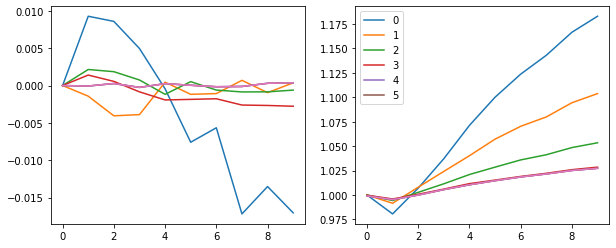

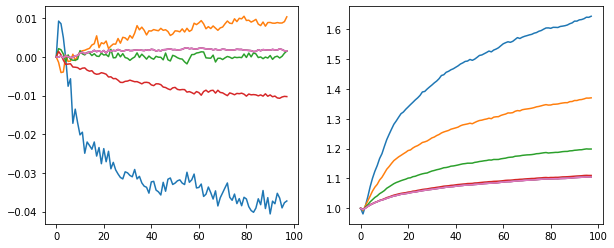

In [21]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

After applying BatchNorm using linear interpolation, we can see the improvement in our standard deviations and means.

In [22]:
learn, run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [23]:
%time run.fit(5, learn)

train: [0.26607884765625, tensor(0.9183, device='cuda:0')]
valid: [0.2518082275390625, tensor(0.9188, device='cuda:0')]
train: [0.08462037109375, tensor(0.9741, device='cuda:0')]
valid: [0.07879784545898437, tensor(0.9751, device='cuda:0')]
train: [0.0603748388671875, tensor(0.9812, device='cuda:0')]
valid: [0.11693089599609376, tensor(0.9633, device='cuda:0')]
train: [0.0490041064453125, tensor(0.9846, device='cuda:0')]
valid: [0.06964392700195313, tensor(0.9784, device='cuda:0')]
train: [0.0403047900390625, tensor(0.9866, device='cuda:0')]
valid: [0.0707970458984375, tensor(0.9793, device='cuda:0')]
CPU times: user 5.89 s, sys: 35.9 ms, total: 5.92 s
Wall time: 4.93 s


### Comparison to Built-in BatchNorm

In [24]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [25]:
learn, run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [26]:
%time run.fit(5, learn)

train: [0.23452498046875, tensor(0.9251, device='cuda:0')]
valid: [0.08072618408203125, tensor(0.9748, device='cuda:0')]
train: [0.06257984375, tensor(0.9802, device='cuda:0')]
valid: [0.1142558837890625, tensor(0.9642, device='cuda:0')]
train: [0.0423348681640625, tensor(0.9868, device='cuda:0')]
valid: [0.07078927001953125, tensor(0.9797, device='cuda:0')]
train: [0.03153028076171875, tensor(0.9903, device='cuda:0')]
valid: [0.057710650634765624, tensor(0.9821, device='cuda:0')]
train: [0.02128148681640625, tensor(0.9938, device='cuda:0')]
valid: [0.05555340576171875, tensor(0.9835, device='cuda:0')]
CPU times: user 5.61 s, sys: 11.9 ms, total: 5.62 s
Wall time: 4.63 s


### Adding the Scheduler

Adding learning rate annealing:


In [27]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)])

In [28]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs +
                           [partial(ParamScheduler, 'lr', sched)])

In [29]:
run.fit(10, learn)

train: [0.242242890625, tensor(0.9275, device='cuda:0')]
valid: [0.1109781005859375, tensor(0.9654, device='cuda:0')]
train: [0.07245439453125, tensor(0.9776, device='cuda:0')]
valid: [0.07864197387695313, tensor(0.9756, device='cuda:0')]
train: [0.05993212890625, tensor(0.9809, device='cuda:0')]
valid: [0.10018829345703124, tensor(0.9698, device='cuda:0')]
train: [0.03866418701171875, tensor(0.9874, device='cuda:0')]
valid: [0.05641264038085937, tensor(0.9833, device='cuda:0')]
train: [0.02331113037109375, tensor(0.9927, device='cuda:0')]
valid: [0.05662333984375, tensor(0.9840, device='cuda:0')]
train: [0.01354578125, tensor(0.9962, device='cuda:0')]
valid: [0.048208865356445314, tensor(0.9855, device='cuda:0')]
train: [0.0076075390625, tensor(0.9980, device='cuda:0')]
valid: [0.04530145263671875, tensor(0.9874, device='cuda:0')]
train: [0.004427695922851562, tensor(0.9991, device='cuda:0')]
valid: [0.04266683349609375, tensor(0.9886, device='cuda:0')]
train: [0.0028356549072265625, 

## Additional Norms

### Layer Norm

General equation for a norm layer with learnable affine:

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

The key difference with BN is:
1. Don't keep moving averages.
2. Don't average over the batch dimension but over the hidden dimension. This makes it independent of batch size.
3. Instead of (0, 2, 3), we now have (1, 2, 3).
4. Not nearly as good as BN, but works well enough on RNNs since we can't use BN in that scenario.

In [30]:
# This is the code implementation of the equation above
class LayerNorm (nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))
        
    def forward(self, x):
        m = x.mean((1, 2, 3), keepdim=True)
        v = x.var((1, 2, 3), keepdim=True)
        x = (x - m) / (v+self.eps).sqrt()
        return x*self.mult + self.add

In [31]:
def conv_layer_norm(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [32]:
learn, run = get_learn_run(nfs, data, 0.8, conv_layer_norm, cbs=cbfs)

In [33]:
%time run.fit(3, learn)

train: [nan, tensor(0.1380, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 4.09 s, sys: 16.1 ms, total: 4.1 s
Wall time: 3.51 s


### Instance Norm

|\begin{equation}\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, the authors propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}

This used for style transfer and **NOT** for image classification. 

A graphical depiction of the different types of norms :

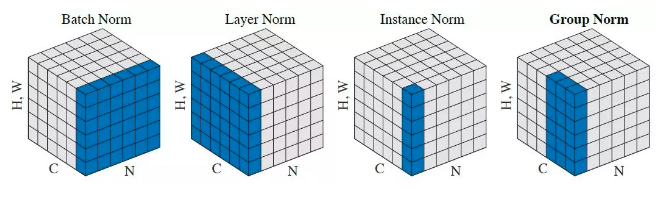

In [34]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [35]:
def conv_instance_norm(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [36]:
learn, run = get_learn_run(nfs, data, 0.1, conv_instance_norm, cbs=cbfs)

In [37]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 4.5 s, sys: 19.6 ms, total: 4.52 s
Wall time: 3.92 s


## Addressing the Issue of Small Batch Sizes

### Problem:

Computing the statistics, i.e. mean and std. deviation, for a BatchNorm Layer on a small batch size gives us a standard deviation very close to 0 due to the lack of sufficient numbers of samples.


In [38]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [39]:
def conv_layer(ni, nf, ks=3, stride=2 , bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [40]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [41]:
%time run.fit(2, learn)

train: [2.3357021875, tensor(0.1712, device='cuda:0')]
valid: [288141.4912, tensor(0.1925, device='cuda:0')]
train: [2.32542328125, tensor(0.1792, device='cuda:0')]
valid: [38715509.9648, tensor(0.2931, device='cuda:0')]
CPU times: user 1min 54s, sys: 775 ms, total: 1min 55s
Wall time: 1min 54s


Extremely small batch sizes also add to the compute overhead!The performance is abysmal!!

### Solution: Running Batch Norm

As indicated in the lessons, the solution is to use Running BatchNorm, which employs smoother running mean and variance for the mean and std dev. 

In [42]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.ones(nf, 1, 1))
        self.register_buffer('sums', torch.zeros(1, nf, 1, 1))
        self.register_buffer('sqrs', torch.zeros(1, nf, 1, 1))
        self.register_buffer('batch', torch.tensor(0.))
        self.register_buffer('count', torch.tensor(0.))
        self.register_buffer('step', torch.tensor(0.))
        self.register_buffer('dbias', torch.tensor(0.))
        
    def update_stats(self, x):
        bs, nc, *_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0, 2, 3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel() / nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1
        
    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums 
        sqrs = self.sqrs
        c = self.count
        if self.step < 100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums / c
        vars = (sqrs / c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x - means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [43]:
# Lets apply the Running BatchNorm to a new Conv learner
def conv_running_bn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride,
                       bias=not bn), GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [44]:
learn, run = get_learn_run(nfs, data, 0.4, conv_running_bn, cbs=cbfs)

In [45]:
%time run.fit(1, learn)

train: [0.63196484375, tensor(0.8098, device='cuda:0')]
valid: [17.473784375, tensor(0.9446, device='cuda:0')]
CPU times: user 2min 18s, sys: 387 ms, total: 2min 19s
Wall time: 2min 18s


### Maxing out the performance in a single epoch

With a more reasonable batch size...

In [46]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [47]:
learn, run = get_learn_run(nfs, data, 0.9, conv_running_bn, cbs=cbfs + 
                          [partial(ParamScheduler, 'lr', sched_lin(1., 0.2))])

In [48]:
%time run.fit(1, learn)


train: [0.246381328125, tensor(0.9263, device='cuda:0')]
valid: [372.079275, tensor(0.9726, device='cuda:0')]
CPU times: user 9.3 s, sys: 28 ms, total: 9.33 s
Wall time: 9.12 s


In [67]:
# Changing batch size
data = DataBunch(*get_dls(train_ds, valid_ds, 128), c)

In [68]:
#cbfs.append(LR_Find)

In [101]:
learn, run = get_learn_run(nfs, data, 0.85, conv_running_bn, cbs=cbfs + 
                          [partial(ParamScheduler, 'lr', sched_lin(0.9, 0.10))])

In [102]:
%time run.fit(1, learn)

train: [0.2676537109375, tensor(0.9299, device='cuda:0')]
valid: [0.09938456420898438, tensor(0.9758, device='cuda:0')]
CPU times: user 2.42 s, sys: 7.91 ms, total: 2.42 s
Wall time: 2.22 s


# Layerwise Sequential Unit Variance (LSUV)

Managing to keep the unit variances of our layer outputs in check as the model trains can prove to be quite a "fiddley" task, especially if we're adding dropout, or changing activation functions. These variations in outputs get exponentially worse as the model trains over multiple epochs.

LSUV shifts this burden to the computer itself.

In [145]:
# Redefining our architecture
nh, bs = 50, 512
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [146]:
# Recreating our ConvLayer class
class ConvLayer(nn.Module):
    # Adding a subtraction hyper parameter
    def __init__(self, ni, nf, ks=3, stride=2, sub=0., **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True)
        self.relu = GeneralRelu(sub=sub, **kwargs)
        
    def forward(self, x): return self.relu(self.conv(x))
    
    @property
    def bias(self): return -self.relu.sub 
    @bias.setter
    def bias(self, v): self.relu.sub = -v
    @property
    def weight(self): return self.conv.weight
    

Create a learner and runner, without really worrying about how it initializes...

In [147]:
learn, run = get_learn_run(nfs, data, 0.6, ConvLayer, cbs=cbfs)

In [148]:
run.fit(2, learn)

train: [1.433776875, tensor(0.5219, device='cuda:0')]
valid: [0.226480224609375, tensor(0.9305, device='cuda:0')]
train: [0.30987103515625, tensor(0.9050, device='cuda:0')]
valid: [0.1582620849609375, tensor(0.9539, device='cuda:0')]


With the initial performance noted, let's recreate the model, this time with LSUV, and we will define a function which grabs a single mini-batch.

In [149]:
learn, run = get_learn_run(nfs, data, 0.6, ConvLayer, cbs=cbfs)

In [150]:
def get_batch(dl, runer):
    run.xb, run.yb = next(iter(dl))
    for cb in run.cbs: cb.set_runner(run)
    run('begin_batch')
    return run.xb, run.yb
    

In [151]:
xb, yb = get_batch(data.train_dl, run)

Now that we have our mini-batch, we will use a function which (using recursion) only gives us the outputs of the convolutional layers.

In [152]:
def find_modules(m, cond):
    if cond(m): return [m]
    return sum([find_modules(o, cond) for o in m.children()], [])

def is_lin_layer(l):
    lin_layers = (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear, nn.ReLu)
    return isinstance(l, lin_layers)

In [153]:
mods = find_modules(learn.model, lambda o: isinstance(o, ConvLayer))

In [154]:
mods

[ConvLayer(
   (conv): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 )]

Adding another helper function to grab the mean and std of the output of a hooked layer.

In [155]:
def append_stat(hook, mod, inp, outp):
    d = outp.data
    hook.mean, hook.std = d.mean().item(), d.std().item()

In [156]:
mdl = learn.model.cuda()

In [157]:
with Hooks(mods, append_stat) as hooks:
    mdl(xb)
    for hook in hooks: print(hook.mean, hook.std)

0.3897072970867157 0.6319916248321533
0.33694127202033997 0.5548509955406189
0.2168125957250595 0.3948383331298828
0.21095244586467743 0.3277290463447571
0.1627117097377777 0.2220781147480011


Here, our means are too high and the std. devs. are not close to 1. Therefore, we will adjust the bias terms to make the means 0 and then std. devs. must be adjusted to 1 (with a threshold of 1e-3). 

In [158]:
def lsuv_module(m, xb):
    h = Hook(m, append_stat)
    
    # mdl(xb) is not None exists to pass xb through mdl while computing
    # all activations in order to update the hooks.
    
    while mdl(xb) is not None and abs(h.mean) > 1e-3: m.bias -= h.mean
    while mdl(xb) is not None and abs(h.std-1)> 1e-3: m.weight.data /= h.std
        
    h.remove()
    return h.mean, h.std

Executing the initialization on all conv layers in order...

In [159]:
for m in mods: print(lsuv_module(m, xb))

(0.22692637145519257, 1.0000001192092896)
(0.11001376807689667, 1.0)
(0.15807662904262543, 0.9999999403953552)
(0.1515551060438156, 1.0000001192092896)
(0.2991049587726593, 1.0)


Now that our means and std. devs. are much more acceptable, the model will begin training on much better grounds.

In [160]:
%time run.fit(2, learn)

train: [0.4551003125, tensor(0.8555, device='cuda:0')]
valid: [0.1386651123046875, tensor(0.9577, device='cuda:0')]
train: [0.113353916015625, tensor(0.9646, device='cuda:0')]
valid: [0.10336754150390624, tensor(0.9667, device='cuda:0')]
CPU times: user 2.37 s, sys: 0 ns, total: 2.37 s
Wall time: 1.97 s


**Note** LSUV is very useful for more complex and deeper architectures where initializations are hard to optimize from the get go.